# QAOA for Portfolio Optimization, Toy Example
In this notebook a small portfolio optimization problem is solved using QAOA. We incorporate the fixed budget constraint using two different methods, namely the penalty method and the XY-mixer method. The quantum circuit used is shown for both methods and the approximation ratio for depth = 1 is computed for the two methods.

# Import neceassry modules

In [1]:
from qaoa import QAOA, problems, mixers, initialstates

In [2]:
from asset_loader import AssetData
from utilities_portOpt import computeMinMaxCosts, computeAverageApproxRatio, approxRatio
from qiskit import *
import numpy as np
import matplotlib.pyplot as pl
from mpl_toolkits.axes_grid1 import make_axes_locatable
from qiskit.visualization import *
import itertools

# Creating problem instance

/home/franzf/OpenQuantumComputing/QAOA/examples/PortfolioOptimization/asset_loader.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=-30)


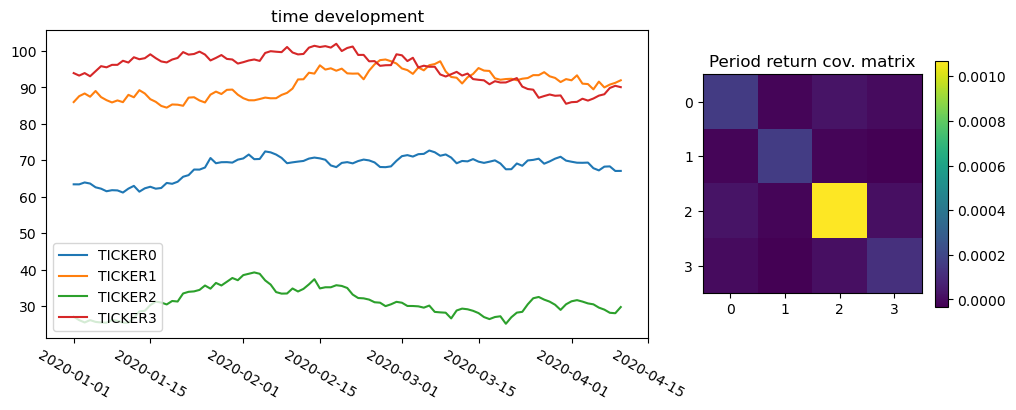

In [3]:
number_of_assets = 4 
budget = 2

filename = os.path.join("data", "qiskit_finance_seeds.npz") #filename of file containing time series of 
                                                            #non-crashing stocks.
seeds = np.load(filename)
assets = AssetData(number_of_assets, seed=seeds[str(number_of_assets)][132])

assets.plotAssets()

# Creating QAOA instances for both methods
Below we create a QAOA instance for both the penalty method and for the XY-mixer method.
The gamma_scale parameter is used to adjust the search range for the gamma parameter. 

For information about the scale parameter see Sebastian Brandhofer et al. “Benchmarking the performance of portfolio optimization with QAOA”. In: Quantum Information Processing 22.1 (2023), page 25-26)
or Zichang He et al. Alignment between Initial State and Mixer Improves QAOA Performance for 
Constrained Portfolio Optimization page 7 (2023)

In [4]:
def DickeVector(n,k):
    result=np.zeros(2**n)
    num=0
    for bits in itertools.combinations(range(n), k):
        num+=1
        khot=0
        for b in bits:
            khot+=2**b
        result[khot]=1
    return result/np.sqrt(num)

In [5]:
initialstates.DickeState(budget)

In [6]:
gamma_scale = 5000 #Adjusts the search range for the gamma parameter 

qaoaport_opt_penalty = QAOA(
    initialstate=initialstates.Plus(),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale,
        penalty = 4*gamma_scale, #Use optimal penalty?????
    ),
    mixer=mixers.X()
)


statevector=DickeVector(number_of_assets, budget)

qaoaport_opt_XYmixer = QAOA(
    initialstate=initialstates.StateVector(statevector=statevector),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale
    ),
    mixer=mixers.XY()
)


qaoaport_opt_XYmixer_dicke = QAOA(
    initialstate=initialstates.DickeState(budget),
    problem=problems.PortfolioOptimization(
        risk=.5*gamma_scale,
        budget=budget,
        cov_matrix=assets.cov_matrix,
        exp_return=assets.exp_return*gamma_scale
    ),
    mixer=mixers.XY()
)

qaoaport_opt_penalty.createParameterizedCircuit(1)
qaoaport_opt_XYmixer.createParameterizedCircuit(1)
qaoaport_opt_XYmixer_dicke.createParameterizedCircuit(1)
#createParameterizedCircuit(depth) must be called to create circuit before drawing.
#The argument "1" of the function is the depth of the circuit
                            

# Drawing quantum circuit for penalty method
Below the quantum circuit for the QAOA method is shown. The circuit corresponds to preparation of the $\gamma$ and $\beta$ dependent state: $|\gamma, \beta\rangle = e^{-iH_{M}\beta}e^{-iH_C\gamma}|0\rangle $, where $|0\rangle$ is the equal superposition over all computational basis state prepared by the hadamard gates. $H_M$ and $H_C$ are the standar X-mixer and the cost hamiltonian respectively.

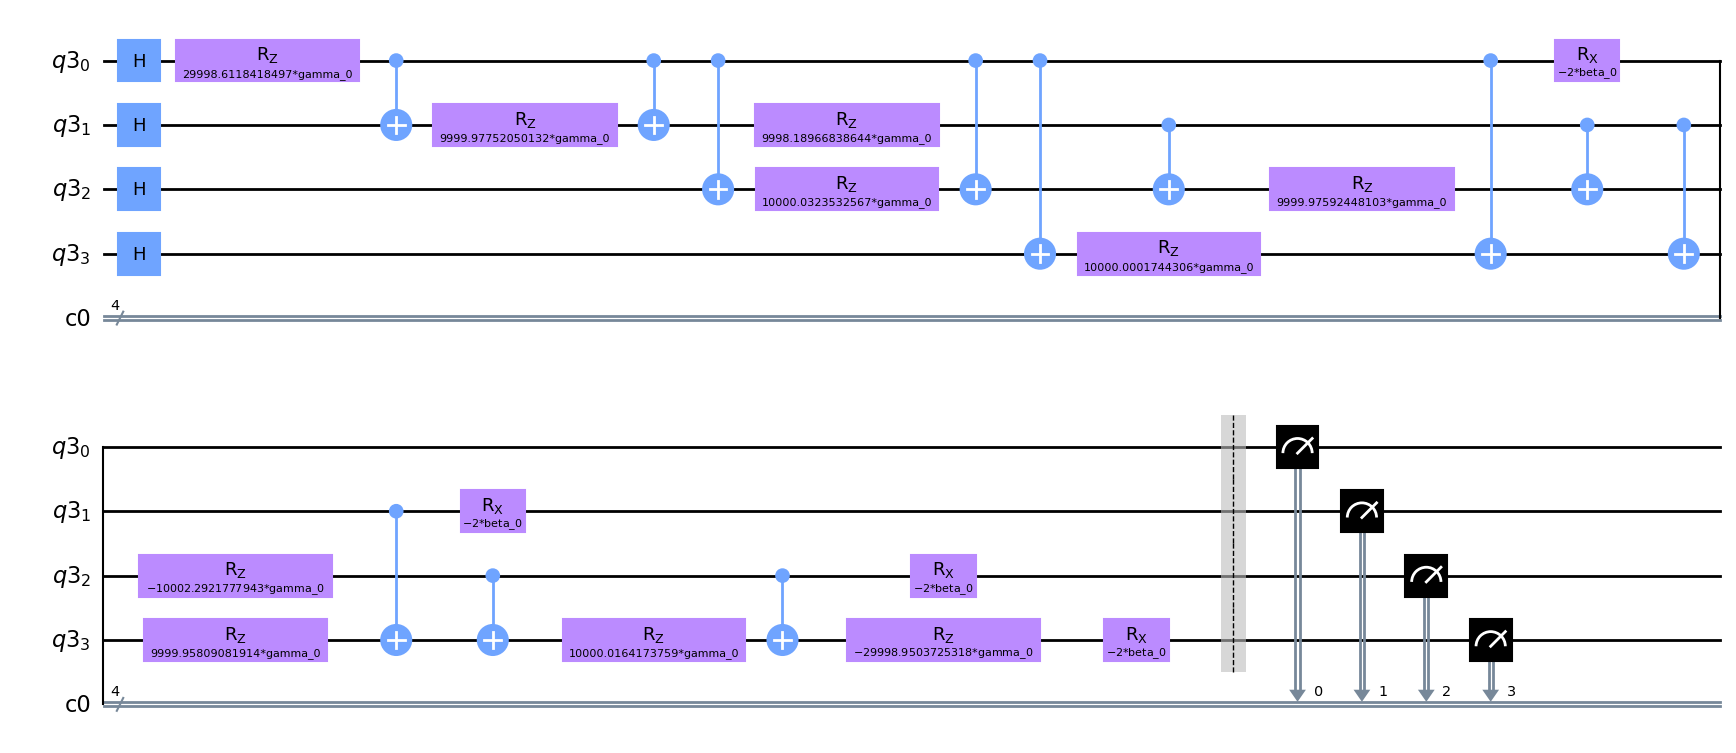

In [7]:
qaoaport_opt_penalty.parameterized_circuit.draw(output = 'mpl')   

# Drawing quantum circuit for XY-mixer method
Below the quantum circuit for the QAOA method is shown. The circuit corresponds to preparation of the $\gamma$ and $\beta$ dependent state: $|\gamma, \beta\rangle = e^{-iH_{M}\beta}e^{-iH_C\gamma}|0\rangle $, where $|0\rangle$ is the equal superposition over all feasible basis states. $H_M$ and $H_C$ are the open XY-mixer and the cost hamiltonian respectively.

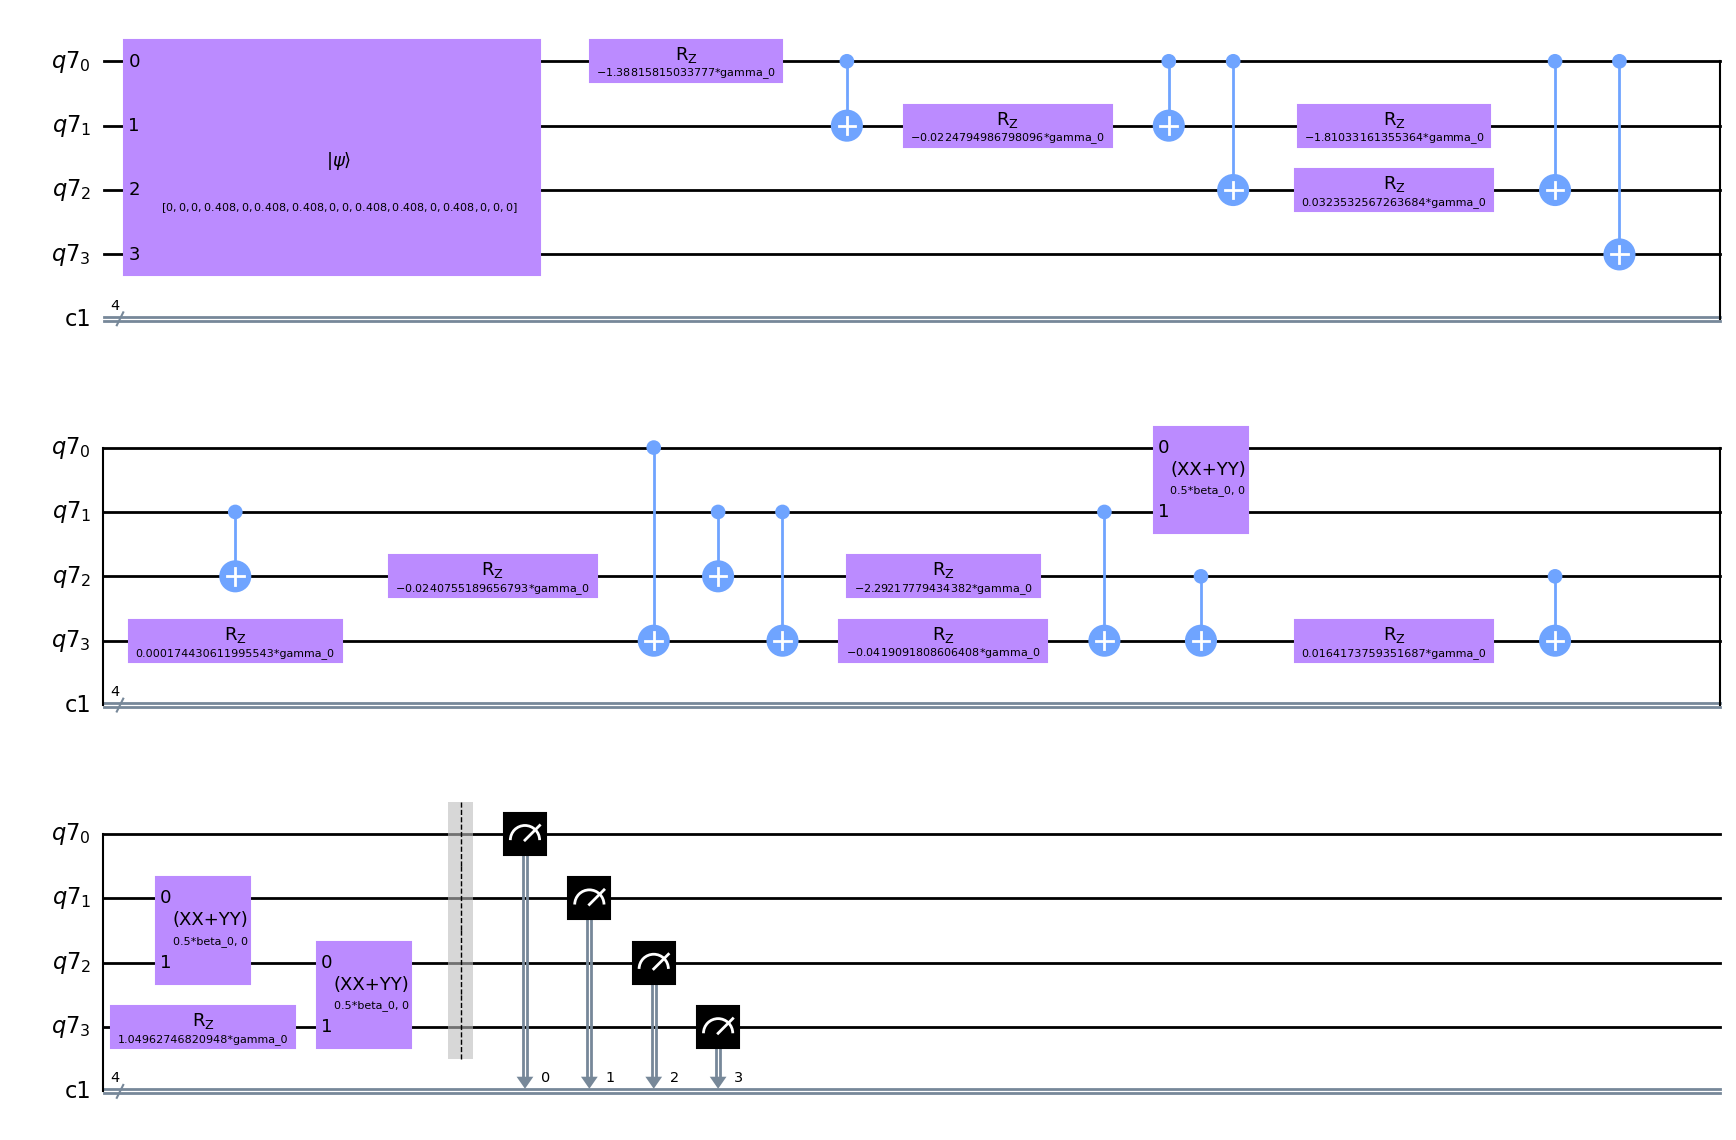

In [8]:
qaoaport_opt_XYmixer.parameterized_circuit.draw(output = 'mpl')  

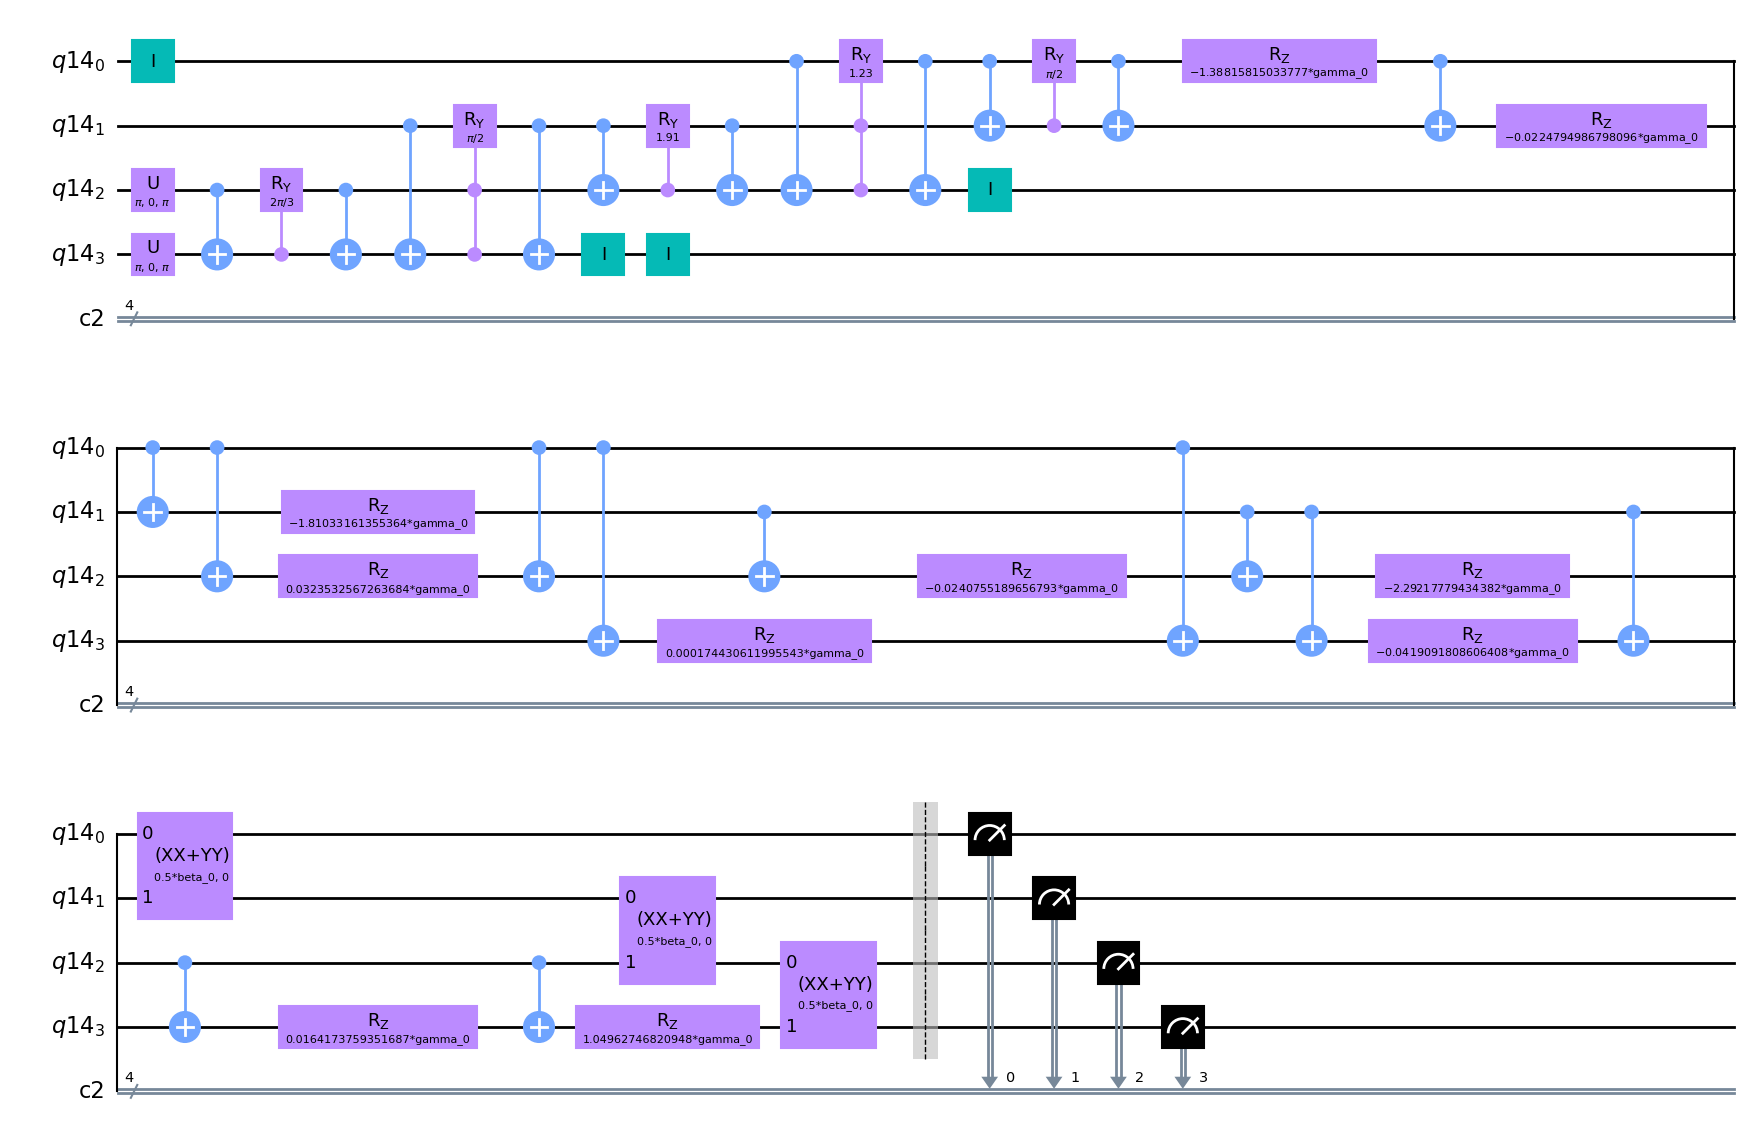

In [9]:
qaoaport_opt_XYmixer_dicke.parameterized_circuit.draw(output = 'mpl')  

# Sample and plot the cost landscape for penalty method
The cost landscape is sampled using angles $\gamma, \beta$ $\in$ $[0, \frac{\pi}{2}]$. The cost landscape is periodic with period $\frac{\pi}{2}$ in $\beta$.

2023-09-25 09:54:34 [info     ] Calculating energy landscape for depth p=1... file=qaoa.qaoa func=sample_cost_landscape
1 0
2023-09-25 09:54:34 [info     ] Executing sample_cost_landscape file=qaoa.qaoa func=sample_cost_landscape
2023-09-25 09:54:34 [info     ] parameters: 2                  file=qaoa.qaoa func=sample_cost_landscape
2023-09-25 09:54:34 [info     ] Done execute                   file=qaoa.qaoa func=sample_cost_landscape
2023-09-25 09:54:34 [info     ] Done measurement               file=qaoa.qaoa func=sample_cost_landscape
2023-09-25 09:54:34 [info     ] Calculating Energy landscape done file=qaoa.qaoa func=sample_cost_landscape


AttributeError: 'QAOA' object has no attribute 'E'

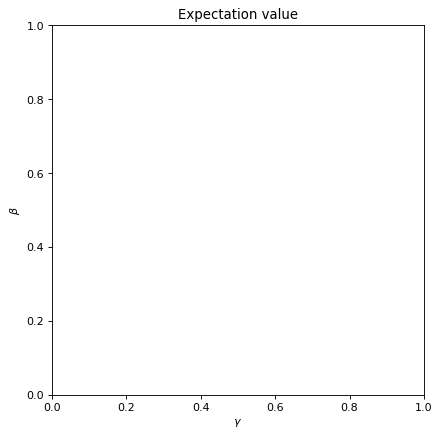

In [10]:
qaoaport_opt_penalty.sample_cost_landscape(angles={"gamma": [0,np.pi/2,10], "beta": [0,np.pi/2,10]})
f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoaport_opt_penalty.E,interpolation='bicubic',origin='lower',extent=[0,np.pi/2,0,np.pi/2])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)

# Sample and plot the cost landscape for XY-mixer method
The cost landscape is sampled using angles $\gamma \in [0, \frac{\pi}{2}]$ and $\beta \in [0, 2\pi]$. In the plot a maximum and minimun of the cost function is seen. The cost landscape is periodic with period $2\pi$ in $\beta$ (different than for the penalty mixer)

In [ ]:
qaoaport_opt_XYmixer.sample_cost_landscape(angles={"gamma": [0,2*np.pi,10], "beta": [0,2*np.pi,10]})
f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoaport_opt_XYmixer.E,interpolation='bicubic',origin='lower',extent=[0,2*np.pi,0,2*np.pi])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)
#Note that the beta range is different for for the penalty method and the XY-mixer method, due to 
#different periods in the mixers.

In [ ]:
qaoaport_opt_XYmixer_dicke.sample_cost_landscape(angles={"gamma": [0,2*np.pi,10], "beta": [0,2*np.pi,10]})
f = pl.figure(figsize=(6, 6), dpi= 80, facecolor='w', edgecolor='k');
_=pl.xlabel(r'$\gamma$')
_=pl.ylabel(r'$\beta$')
ax = pl.gca()
_=pl.title('Expectation value')
im = ax.imshow(qaoaport_opt_XYmixer_dicke.E,interpolation='bicubic',origin='lower',extent=[0,2*np.pi,0,2*np.pi])
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
_=pl.colorbar(im, cax=cax)
#Note that the beta range is different for for the penalty method and the XY-mixer method, due to 
#different periods in the mixers.

# Search for the best parameters at depth = 1 and plot histogram for both methods
The values for the parameters $\gamma$ and $\beta$ are found by the optimizer, and the circuit is then measured 2048 times. The measurement outcome is seen in the histogram below. One can see that all the measruement outcomes (pink) for XY-mixer method is in the feasible subspace, while for the penalty method some measured strings are infeasible.

In [ ]:
qaoaport_opt_penalty.increase_depth()
qaoaport_opt_XYmixer.increase_depth()
qaoaport_opt_XYmixer_dicke.increase_depth()
histogram_penalty = qaoaport_opt_penalty.hist(qaoaport_opt_penalty.angles_hist['d'+str(1)+'_final'])
histogram_XYmixer = qaoaport_opt_XYmixer.hist(qaoaport_opt_XYmixer.angles_hist['d'+str(1)+'_final'])
histogram_XYmixer_dicke = qaoaport_opt_XYmixer.hist(qaoaport_opt_XYmixer_dicke.angles_hist['d'+str(1)+'_final'])
legend = ['Penalty', 'XY-mixer', 'XY-dicke']
plot_distribution([histogram_penalty, histogram_XYmixer, histogram_XYmixer_dicke], legend = legend)


# Compute and print optimal solution with minimum cost

In [ ]:
min_cost, max_cost, solution = computeMinMaxCosts(number_of_assets, qaoaport_opt_penalty.cost, qaoaport_opt_penalty.isFeasible)
print("Optimal solution: ", solution, "\n With cost: ", min_cost)

# Compute and print approximation ratio
Below the approximation ratio for the two methods are computed.

In [ ]:
approx_ratio_penalty = computeAverageApproxRatio(histogram_penalty, max_cost, min_cost, qaoaport_opt_penalty.cost, qaoaport_opt_penalty.isFeasible)
approx_ratio_XYmixer = computeAverageApproxRatio(histogram_XYmixer, max_cost, min_cost, qaoaport_opt_XYmixer.cost, qaoaport_opt_XYmixer.isFeasible)
approx_ratio_XYmixer_dicke = computeAverageApproxRatio(histogram_XYmixer_dicke, max_cost, min_cost, qaoaport_opt_XYmixer_dicke.cost, qaoaport_opt_XYmixer_dicke.isFeasible)
print("Approximation ratio (penalty method): ", approx_ratio_penalty)
print("Approximation ratio (XY-mixer method): ", approx_ratio_XYmixer)
print("Approximation ratio (XY-mixer Dicke method): ", approx_ratio_XYmixer_dicke)

# Compute and print approximation ratio (SECOND WAY)

In [ ]:
approx_ratio_penalty2 = approxRatio(list(qaoaport_opt_penalty.costval.values()), max_cost, min_cost)
approx_ratio_XYmixer2 = approxRatio(list(qaoaport_opt_XYmixer.costval.values()), max_cost, min_cost)
approx_ratio_XYmixer_dicke2 = approxRatio(list(qaoaport_opt_XYmixer_dicke.costval.values()), max_cost, min_cost)
print("Approximation ratio (penalty method): ", approx_ratio_penalty2)
print("Approximation ratio (XY-mixer method): ", approx_ratio_XYmixer2)
print("Approximation ratio (XY-mixer Dicke method): ", approx_ratio_XYmixer_dicke2)

# Difference between approximation ratio and approximation ratio2
Approximation ratio uses the hist function, which measures the parameterized circuit 1024 times with parameters bounded to the value the optimization found. Then the approximation ratio is found by averaging over the measurement outcomes (based on the plotted hist).
Approximation ratio 2 uses the costval.values() list which is updated during the optimization with a given cost. OBS: When we are not using the CVaR method, these values should give approximately identical results.